# Final Project DATA*6100

This is the final project for DATA*6100. We were given Movielens Dataset for this task. We need to predict the rating for the movie according on the testing dataset. We are going to use regression analysis for this project. We are going to do the following steps in this project:
- Importing Libraries and Dataset
- Data Preprocessing
- Model and model runing
- Final model training and make prediction on test

## Importing Libraries and loading dataset

**We are importing several essential libraries that we will use for data handling, visualization, and modeling.**

In [ ]:
import numpy as np           # For numerical computations and array operations
import pandas as pd          # For handling dataframes and data manipulation
import matplotlib.pyplot as plt  # For creating plots and data visualizations
import seaborn as sns        # For advanced data visualization built on top of matplotlib
from sklearn.preprocessing import LabelEncoder   # For converting categorical features into numerical codes
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from xgboost.callback import TrainingCallback
from sklearn.preprocessing import MultiLabelBinarizer

**Here we are using raw links that we uploaded on github repository for loading datasets using pandas library.**

In [ ]:
url1 = "https://raw.githubusercontent.com/HarshTiwari1710/DATA-6100-Final-Project/refs/heads/main/links%20(1).csv"
url2 = "https://raw.githubusercontent.com/HarshTiwari1710/DATA-6100-Final-Project/refs/heads/main/movie_ratings_test%20(1).csv"
url3 = "https://raw.githubusercontent.com/HarshTiwari1710/DATA-6100-Final-Project/refs/heads/main/movie_ratings_train%20(1).csv"
url4 = "https://raw.githubusercontent.com/HarshTiwari1710/DATA-6100-Final-Project/refs/heads/main/movies%20(1).csv"

In [ ]:
links_df = pd.read_csv(url1)
test_df = pd.read_csv(url2)
train_df = pd.read_csv(url3)
movie_name_df = pd.read_csv(url4)

In [ ]:
# first few rows of dataset
print(links_df.head())
print(test_df.head())
print(train_df.head())
print(movie_name_df.head())

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
   userId  movieId  timestamp
0       1      349  964982563
1       1      592  964982271
2       1      780  964984086
3       1     1196  964981827
4       1     1208  964983250
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adven

In [ ]:
print(links_df.shape)
print(test_df.shape)
print(train_df.shape)
print(movie_name_df.shape)

(9742, 3)
(10000, 3)
(90836, 4)
(9742, 3)


* We have 4 datasets out of which links.csv include imdb and tmdd identifiers which we will not use for training and making prediction. movie_df has movie names we will merge with test and training dataframe.
* Test dataframe has 10000 rows and training df has 90836 rows of data.

## Data Preprocessing

**Then, we have merged the movie names from movie_name_df dataset with both test and train df. Followed by adding label marker 0 and 1 to both train and test respectively for later merging the files for feature engineering.**

In [ ]:
train_data_merged = pd.merge(train_df, movie_name_df, on='movieId')
test_data_merged = pd.merge(test_df, movie_name_df, on='movieId')

# Adding a 'set_type' column to distinguish between train and test data for future use
train_data_merged['marker'] = 0  # 0 for training data
test_data_merged['marker'] = 1   # 1 for test data

In [ ]:
print(train_data_merged)
print(test_data_merged)

       userId  movieId  rating   timestamp                           title  \
0           1        1     4.0   964982703                Toy Story (1995)   
1           1        3     4.0   964981247         Grumpier Old Men (1995)   
2           1        6     4.0   964982224                     Heat (1995)   
3           1       47     5.0   964983815     Seven (a.k.a. Se7en) (1995)   
4           1       50     5.0   964982931      Usual Suspects, The (1995)   
...       ...      ...     ...         ...                             ...   
90831     610   166534     4.0  1493848402                    Split (2017)   
90832     610   168248     5.0  1493850091   John Wick: Chapter Two (2017)   
90833     610   168250     5.0  1494273047                  Get Out (2017)   
90834     610   168252     5.0  1493846352                    Logan (2017)   
90835     610   170875     3.0  1493846415  The Fate of the Furious (2017)   

                                            genres  marker  
0 

### Data cleaning

**The column timestamp was dropped from the train_data_merged and test_data_merged because we saw the values in the columns felt that they were irrelevant based on our task as time stamp can be used in time series analysis.**

In [ ]:
# removing timestamp column
train_data_merged = train_data_merged.drop(['timestamp'],axis=1)
test_data_merged = test_data_merged.drop(['timestamp'],axis=1)

In [ ]:
# exploring training and testing dataframe
print(train_data_merged.info())
print(test_data_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   90836 non-null  int64  
 1   movieId  90836 non-null  int64  
 2   rating   90836 non-null  float64
 3   title    90836 non-null  object 
 4   genres   90836 non-null  object 
 5   marker   90836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.2+ MB


In [ ]:
# exploring training and testing dataframe
print(train_data_merged.describe())
print(test_data_merged.describe())

,userId,movieId,rating,marker
count,90836.000000,90836.000000,90836.000000,90836.0
mean,327.538740,20486.298835,3.481577,0.0
std,182.740846,36564.010987,1.047404,0.0
min,1.000000,1.000000,0.500000,0.0
25%,177.000000,1216.000000,3.000000,0.0
50%,328.000000,3147.500000,3.500000,0.0
75%,477.000000,8665.000000,4.000000,0.0
max,610.000000,193609.000000,5.000000,0.0


In [ ]:
print("Null values in Test data columns",test_data_merged.isna().sum())
print("Null values in Train data columns",train_data_merged.isna().sum())

Null values in Test data columns userId     0
movieId    0
title      0
genres     0
marker     0
dtype: int64
Null values in Train data columns userId     0
movieId    0
rating     0
title      0
genres     0
marker     0
dtype: int64


No null values in any of the columns for both test and train dataframes

In [ ]:
train_data_merged.columns

Index(['userId', 'movieId', 'rating', 'title', 'genres', 'marker'], dtype='object')

In [ ]:
train_data_merged['genre_list'] = train_data_merged['genres'].str.split('|')
test_data_merged['genre_list'] = test_data_merged['genres'].str.split('|')

Then, we combined cleaned data into one frame to make them ready for modelling and prediction

In [ ]:
combined_data = pd.concat([train_data_merged, test_data_merged])

## Basic exploration of variables

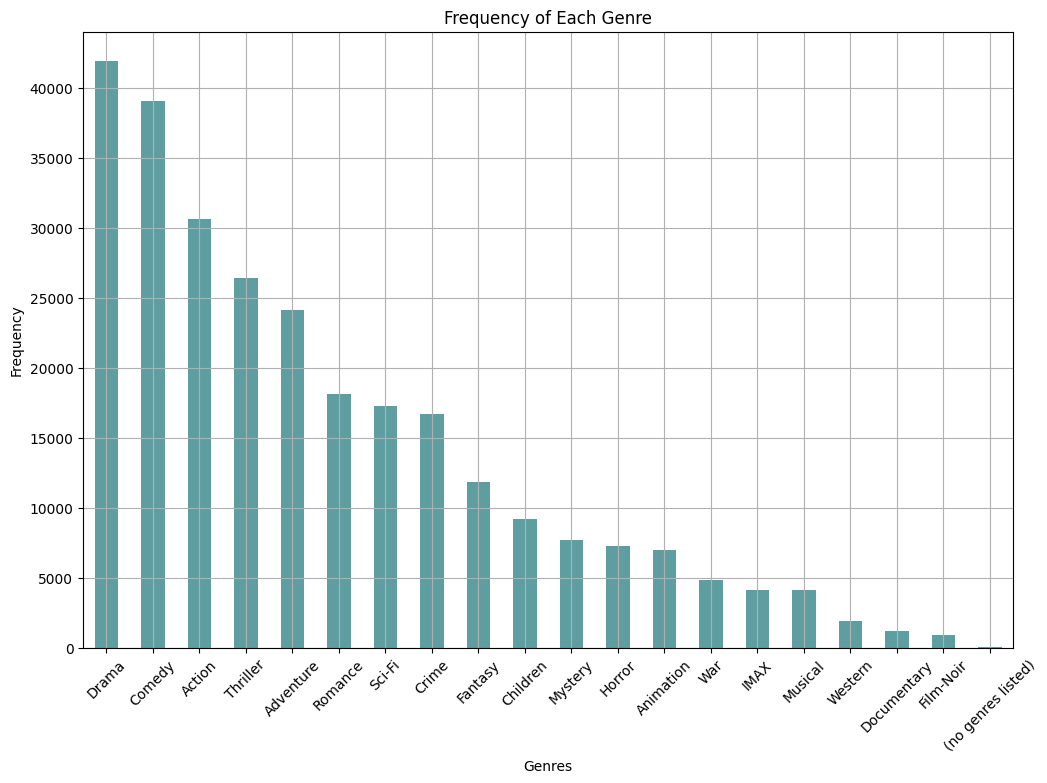

In [ ]:
combined_data['genre_list'] = combined_data['genres'].str.split('|')

# Explode the DataFrame so each genre gets its own row
exploded_genres = combined_data.explode('genre_list')
genre_counts = exploded_genres['genre_list'].value_counts()
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar', color='cadetblue')
plt.title('Frequency of Each Genre')
plt.xlabel('Genres')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate genre labels to make them readable
plt.grid(True)
plt.show()

This genre distribution shows Drama leading significantly with over 40,000 titles, followed closely by Comedy and Action. There's a clear long-tail distribution where the top 5 genres (Drama, Comedy, Action, Thriller, Adventure) account for the majority of content, while niche genres like Documentary and Film-Noir have much lower representation with less than 2,000 titles each. This distribution likely reflects both viewer preferences and production economics, where mainstream genres attract larger audiences and therefore more investment.

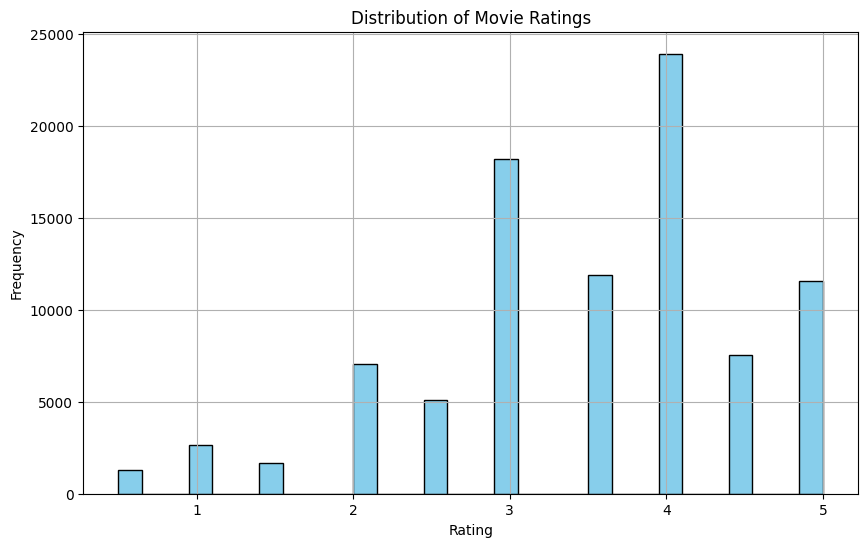

In [ ]:
ratings = combined_data['rating']
plt.figure(figsize=(10, 6))
plt.hist(ratings, bins=30, color='skyblue', edgecolor='black')  # Adjust bins as needed
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

This histogram displays the distribution of movie ratings in a dataset, ranging from 1 to 5. The frequency of each rating is plotted, showing that ratings of 4 are the most common, followed by ratings of 3 and 5

### Feature engineering

**we engaged in substantial feature engineering to enhance the predictive capability of our model. We introduced user and movie-based statistical features such as average ratings, standard deviations, and count of ratings for both movies and users. These features capture the general sentiment and variability of ratings, providing insights into user preferences and movie popularity**

In this section  we created movie-based features by calculating key statistics for each movie across all ratings. The features include:
- Average rating: Captures overall movie quality
- Rating standard deviation: Measures rating consistency/controversy
- Rating count: Indicates movie popularity and rating reliability

These aggregated features will help capture movie-specific patterns in the recommendation system.

In [ ]:
# Movie-based features
movie_stats = train_data_merged.groupby('movieId').agg({
    'rating': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
movie_stats.columns = ['movieId', 'movie_avg_rating', 'movie_rating_std', 'movie_rating_count']

# Fill NaN values in std with 0 for movies with only one rating
movie_stats['movie_rating_std'] = movie_stats['movie_rating_std'].fillna(0)

# Let's look at what we created
print("Movie stats head:")
print(movie_stats.head())

Movie stats head:
   movieId  movie_avg_rating  movie_rating_std  movie_rating_count
0        1          3.880814          0.849171                 172
1        2          3.405882          0.871145                  85
2        3          3.131579          1.024591                  38
3        4          2.357143          0.852168                   7
4        5          3.115385          0.756216                  39


#### Building User Behavior Features

Then we creatED user-specific features to understand individual rating patterns. For each user, we calculated:
- Their average rating - reveals if they tend to be generous or strict in ratings
- Standard deviation - shows how varied their ratings are
- Total ratings given - indicates how active they are on the platform

These metrics will help me better understand and predict each user's rating behavior.

In [ ]:
# User-based features
user_stats = train_data_merged.groupby('userId').agg({
    'rating': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
user_stats.columns = ['userId', 'user_avg_rating', 'user_rating_std', 'user_rating_count']

# Fill NaN values in std with 0 for users with only one rating
user_stats['user_rating_std'] = user_stats['user_rating_std'].fillna(0)

print("\nUser stats head:")
print(user_stats.head())


User stats head:
   userId  user_avg_rating  user_rating_std  user_rating_count
0       1         4.384615         0.796219                208
1       2         3.948276         0.805615                 29
2       3         2.435897         2.090642                 39
3       4         3.540107         1.340938                187
4       5         3.605263         0.973694                 38


#### Additionally calculating Genre preferences for each user

To add data about user preferences we tried breaking down ratings by genre. For each user, we calculated their average rating across every movie genre. This helped us:
- Understand their genre-specific preferences
- Identify if they had consistently rated certain genres higher or lower
- Capture subtle rating patterns that might have been masked in overall averages

For instance, a user might have generally given high ratings but had been particularly critical of horror movies - this was exactly the kind of insight we had been trying to capture.

In [ ]:
# First look at genre_list
print("\nSample of genre_list:")
print(train_data_merged['genre_list'].head())

# Calculate average rating per user per genre and fill NaN with 0
user_genre_ratings = train_data_merged.groupby('userId').apply(
    lambda group: pd.Series({
        f'user_avg_{genre.lower()}_rating': group[group['genre_list'].apply(
            lambda x: genre in x
        )]['rating'].mean()
        for genre in ['Action', 'Adventure', 'Animation', 'Children',
                     'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                     'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
                     'Sci-Fi', 'Thriller', 'War', 'Western','IMAX','(no genres listed)']
    })
).reset_index()

# Fill NaN values with 0
user_genre_ratings = user_genre_ratings.fillna(0)

print("\nUser genre ratings head (after filling NaN with 0):")
print(user_genre_ratings.head())

# Print shape to see how many features we created
print("\nShape of user_genre_ratings:", user_genre_ratings.shape)


Sample of genre_list:
0    [Adventure, Animation, Children, Comedy, Fantasy]
1                                    [Comedy, Romance]
2                            [Action, Crime, Thriller]
3                                  [Mystery, Thriller]
4                           [Crime, Mystery, Thriller]
Name: genre_list, dtype: object

User genre ratings head (after filling NaN with 0):
   userId  user_avg_action_rating  user_avg_adventure_rating  \
0       1                4.381579                   4.440000   
1       2                3.954545                   4.166667   
2       3                3.571429                   2.727273   
3       4                3.157895                   3.400000   
4       5                3.250000                   3.333333   

   user_avg_animation_rating  user_avg_children_rating  \
0                   4.689655                  4.547619   
1                   0.000000                  0.000000   
2                   0.500000                  0.500000   


<ipython-input-167-15a00df38f46>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_genre_ratings = train_data_merged.groupby('userId').apply(


# Final Feature Integration and Dataset Preparation

We combined several key feature groups to create our comprehensive dataset:

1. Movie Statistics Features:
  - movie_avg_rating: Average rating each movie had received
  - movie_rating_std: How varied the ratings had been for each movie
  - movie_rating_count: How many times each movie had been rated

2. User Behavior Features:
  - user_avg_rating: Each user's typical rating behavior
  - user_rating_std: How consistently each user had rated
  - user_rating_count: How active each user had been

3. Genre Preference Features:
  - user_avg_[genre]_rating: How each user had rated specific genres
  - 20 columns, one for each unique genre including IMAX and ungenred films

We had merged these features with our base dataset and handled missing values by using mean imputation, ensuring our dataset was ready for modeling.

In [ ]:
# Merge all features
result = combined_data.merge(movie_stats, on='movieId', how='left')
result = result.merge(user_stats, on='userId', how='left')
result = result.merge(user_genre_ratings, on='userId', how='left')

# Fill any remaining NaN values with column means
for col in result.columns:
    if col.startswith(('movie_', 'user_')):
        result[col] = result[col].fillna(result[col].mean())

print("\nFinal dataset head:")
print(result.head())
print("\nFinal dataset columns:")
print(result.columns.tolist())


Final dataset head:
   userId  movieId  rating                        title  \
0       1        1     4.0             Toy Story (1995)   
1       1        3     4.0      Grumpier Old Men (1995)   
2       1        6     4.0                  Heat (1995)   
3       1       47     5.0  Seven (a.k.a. Se7en) (1995)   
4       1       50     5.0   Usual Suspects, The (1995)   

                                        genres  marker  \
0  Adventure|Animation|Children|Comedy|Fantasy       0   
1                               Comedy|Romance       0   
2                        Action|Crime|Thriller       0   
3                             Mystery|Thriller       0   
4                       Crime|Mystery|Thriller       0   

                                          genre_list  movie_avg_rating  \
0  [Adventure, Animation, Children, Comedy, Fantasy]          3.880814   
1                                  [Comedy, Romance]          3.131579   
2                          [Action, Crime, Thriller] 

In [ ]:
# copying the new engineered data frame
combined_data = result

In [ ]:
#Showing new engineered columns
combined_data.columns

Index(['userId', 'movieId', 'rating', 'title', 'genres', 'marker',
       'genre_list', 'movie_avg_rating', 'movie_rating_std',
       'movie_rating_count', 'user_avg_rating', 'user_rating_std',
       'user_rating_count', 'user_avg_action_rating',
       'user_avg_adventure_rating', 'user_avg_animation_rating',
       'user_avg_children_rating', 'user_avg_comedy_rating',
       'user_avg_crime_rating', 'user_avg_documentary_rating',
       'user_avg_drama_rating', 'user_avg_fantasy_rating',
       'user_avg_film-noir_rating', 'user_avg_horror_rating',
       'user_avg_musical_rating', 'user_avg_mystery_rating',
       'user_avg_romance_rating', 'user_avg_sci-fi_rating',
       'user_avg_thriller_rating', 'user_avg_war_rating',
       'user_avg_western_rating', 'user_avg_imax_rating',
       'user_avg_(no genres listed)_rating'],
      dtype='object')

### One-Hot Encoding for Movie Genres

We had transformed our movie genre data using one-hot encoding for better model compatibility:

1. Used MultiLabelBinarizer since movies could belong to multiple genres
2. Created binary columns (0/1) for each possible genre
3. Merged these new features with our main dataset
4. Removed the original genre columns ('genres' and 'genre_list')

For example, if a movie had been tagged as "Action, Adventure", it would have received 1s in both the Action and Adventure columns, and 0s for all other genres. This transformation had made our categorical genre data suitable for machine learning algorithms.

In [ ]:
# Initialize and fit the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(combined_data['genre_list'])

# Create a DataFrame from the encoded genres and name the columns
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=combined_data.index)

# Concatenate with the original DataFrame
combined_data = pd.concat([combined_data, genres_encoded_df], axis=1)

In [ ]:
combined_data.shape

(100836, 53)

* Removed the original genre columns ('genres' and 'genre_list')

In [ ]:
combined_data = combined_data.drop('genres',axis=1)
combined_data = combined_data.drop('genre_list',axis=1)


In [ ]:
combined_data.head()

,userId,movieId,rating,title,marker,movie_avg_rating,movie_rating_std,movie_rating_count,user_avg_rating,user_rating_std,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,Toy Story (1995),0,3.880814,0.849171,172,4.384615,0.796219,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,Grumpier Old Men (1995),0,3.131579,1.024591,38,4.384615,0.796219,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,Heat (1995),0,3.975000,0.837794,80,4.384615,0.796219,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),0,3.945513,0.927316,156,4.384615,0.796219,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,"Usual Suspects, The (1995)",0,4.221557,0.826163,167,4.384615,0.796219,...,0,0,0,0,1,0,0,1,0,0


### Dropping Non-Predictive Text Fields for memory optimization

We decided to drop the 'title' column from our dataset for several reasons:

1. Text Complexity: Movie titles had been raw text data that would have required complex NLP processing to extract meaningful features
2. Model Efficiency: Keeping titles would have significantly increased our feature space without clear predictive value for example in 1000s
3. Memory Optimization: Removing text fields had helped reduce memory usage and computation time as we also tried hashvectorizer but the feature number increased thousands and which lead to crashing collab notebook as it was memory extensive so we decided to not use them.

While titles might have contained some signal (e.g., sequels or naming conventions), we had determined that our existing numerical and categorical features had captured the essential information for rating prediction.

In [ ]:
combined_data = combined_data.drop('title',axis=1)


We removed the 'userId' and 'movieId' columns from our training dataset for several reasons:

1. Feature Independence: These IDs had been arbitrary identifiers that didn't carry inherent meaning for prediction
2. Model Generalization: Using IDs might have led to overfitting on specific users or movies rather than learning general patterns
3. Focus on Behaviors: Our engineered features (averages, counts, genres) had already captured the important user and movie characteristics
4. Transfer Learning: Removing IDs had made our model more adaptable to new users and movies not seen during training

While we had kept these IDs during feature engineering to enable proper joins and aggregations, they were no longer needed for the actual model training phase.

In [ ]:
combined_data = combined_data.drop(['userId','movieId'],axis=1)

In [ ]:
print(combined_data.shape)

(100836, 48)


In [ ]:
train_data = combined_data[combined_data['marker'] == 0].drop('marker', axis=1)
test_data = combined_data[combined_data['marker'] == 1].drop(['marker', 'rating'], axis=1)

In [ ]:
X = train_data.drop('rating',axis=1)
y = train_data['rating']

In [ ]:
print(test_data.shape)
print(train_data.shape)

(10000, 46)
(90836, 47)


Now, we have training data set with 90836 rows and 47 columns including target column rating and testing data with 10000 rows and 26 columns. These are ready for modelling

## Model and Model tuning
### XGBOOST(Extreme Gradient Boosting)
---

An Advanced Implimentation of gradient boosting solves our problem in three steps:
•⁠  ⁠Training Phase
•⁠  ⁠Prediction phase
•⁠  ⁠Decision Threshold

It's objective function is given by:
$$
\text{Obj} = \sum_{i=1}^{n} L(y_i, \hat{y}i) + \sum{k=1}^{K} \Omega(f_k)
$$
Where,
$L(y_i,\hat{y}_i) $ is the binary logistic loss function, measuring the diffrence between actual and predicted probablities.

### Hyperparameter tuning with Grid Search and k-fold Cross-Validation

This section implements a comprehensive grid search over key XGBoost parameters using 5-fold cross-validation. The search space explores different combinations of tree depth, learning rate (eta), and sampling parameters to find the optimal model configuration while avoiding overfitting. Each parameter set is evaluated using RMSE averaged across all folds.

Parameters being tuned:
- max_depth: Controls tree complexity
- eta: Learning rate for gradient descent
- subsample: Row sampling for each tree
- colsample_bytree: Column sampling for each tree

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [6, 8],
    'eta': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8]
}

# Split the training data into train and validation sets
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_params = None
best_rmse = float("inf")

print("Starting Hyperparameter Tuning...")

# Grid search
for max_depth in param_grid['max_depth']:
    for eta in param_grid['eta']:
        for subsample in param_grid['subsample']:
            for colsample_bytree in param_grid['colsample_bytree']:
                # Define current parameter set
                params = {
                    'objective': 'reg:squarederror',
                    'max_depth': max_depth,
                    'eta': eta,
                    'subsample': subsample,
                    'colsample_bytree': colsample_bytree,
                    'seed': 42
                }

                rmse_list = []

                # Perform k-fold cross-validation
                for train_idx, val_idx in kf.split(X):
                    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                    dtrain = xgb.DMatrix(X_train, label=y_train)
                    dval = xgb.DMatrix(X_val, label=y_val)

                    model = xgb.train(
                        params, dtrain, num_boost_round=1000,
                        evals=[(dtrain, 'train'), (dval, 'eval')],
                        early_stopping_rounds=50, verbose_eval=False
                    )

                    # Predict and evaluate
                    y_val_pred = model.predict(dval)
                    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
                    rmse_list.append(rmse)

                avg_rmse = np.mean(rmse_list)

                # Update best parameters if this set is better
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_params = params

                print(f"Tested params: {params}, Average RMSE: {avg_rmse}")

print("\nBest parameters found: ", best_params)
print(f"Best RMSE: {best_rmse}")

Starting Hyperparameter Tuning...
Tested params: {'objective': 'reg:squarederror', 'max_depth': 6, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'seed': 42}, Average RMSE: 0.7548058565996125
Tested params: {'objective': 'reg:squarederror', 'max_depth': 6, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.8, 'seed': 42}, Average RMSE: 0.7531435030101905
Tested params: {'objective': 'reg:squarederror', 'max_depth': 6, 'eta': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.6, 'seed': 42}, Average RMSE: 0.7546074347670727
Tested params: {'objective': 'reg:squarederror', 'max_depth': 6, 'eta': 0.01, 'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42}, Average RMSE: 0.7531327798123816
Tested params: {'objective': 'reg:squarederror', 'max_depth': 6, 'eta': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6, 'seed': 42}, Average RMSE: 0.7465785572864985
Tested params: {'objective': 'reg:squarederror', 'max_depth': 6, 'eta': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.8, 'seed': 42},

### Tuned Model validation visulalization
Here, we have tested the model parameters on validation set for Visualization
* we used the callback class that tracks model metrics during training and generates a plot showing training and validation error over boosting iterations.

Validation RMSE: 75 per Hundredth of a Star


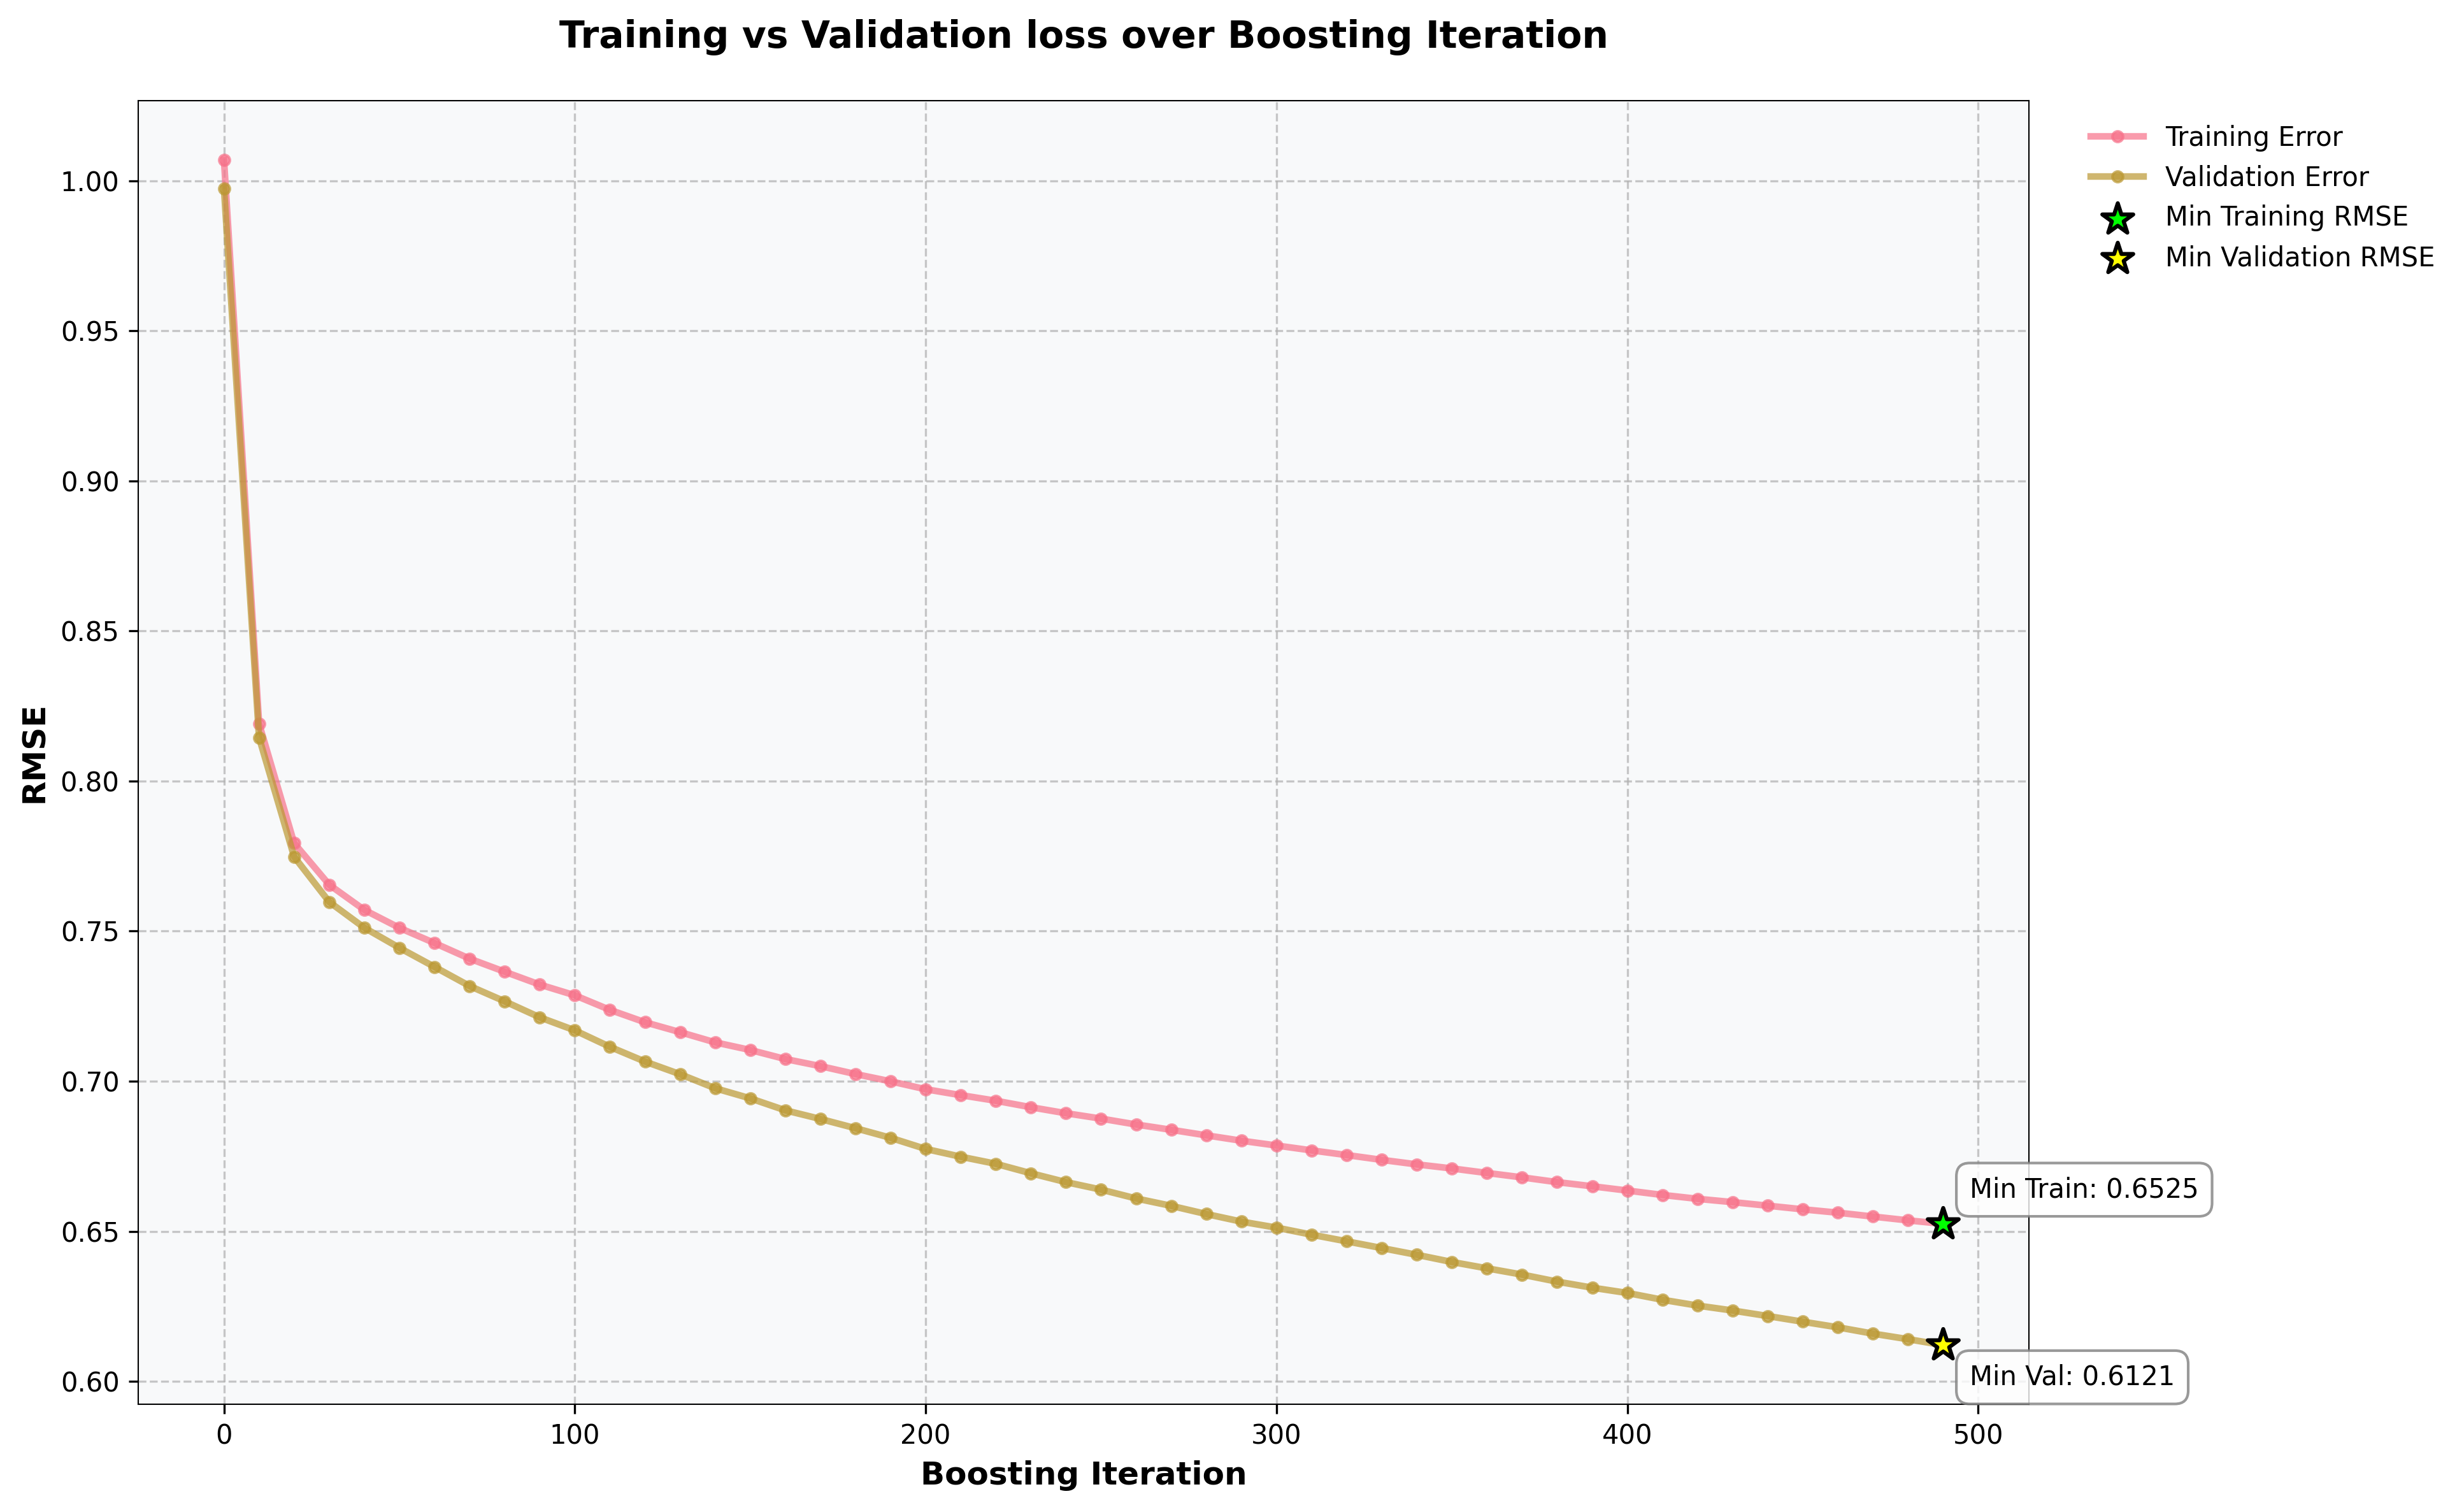

In [ ]:
# Define parameters for the XGBoost model
best_params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Create a proper callback class
class MetricHistory(TrainingCallback):
    def __init__(self):
        self.eval_results = []

    def after_iteration(self, model, epoch, evals_log):
        """Called after each iteration."""
        if epoch % 10 == 0:  # Save metrics every 10 iterations
            self.eval_results.append({
                'iteration': epoch,
                'train': evals_log['train']['rmse'][-1],
                'eval': evals_log['eval']['rmse'][-1]
            })
        return False  # Return False to indicate training should continue

# Train the model with the callback
metric_history = MetricHistory()
model = xgb.train(best_params, dtrain, num_boost_round=500, evals=evallist,
                  early_stopping_rounds=50, evals_result=results, verbose_eval=False,callbacks=[metric_history])


# Evaluate the model on the validation set
y_val_pred = model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE: {round(rmse*100)} per Hundredth of a Star")

# Plot training progress
sns.set_palette("husl")

# Create the figure with a higher DPI for better quality
plt.figure(figsize=(13, 8), dpi=300)

# Create the plot with enhanced styling
eval_df = pd.DataFrame(metric_history.eval_results)

# Find minimum points
min_train_idx = eval_df['train'].idxmin()
min_train_point = eval_df.iloc[min_train_idx]
min_val_idx = eval_df['eval'].idxmin()
min_val_point = eval_df.iloc[min_val_idx]

# Plot lines with enhanced styling
plt.plot(eval_df['iteration'], eval_df['train'], label='Training Error',
         linewidth=2.5, marker='o', markersize=4, alpha=0.7)
plt.plot(eval_df['iteration'], eval_df['eval'], label='Validation Error',
         linewidth=2.5, marker='o', markersize=4, alpha=0.7)

# Highlight minimum points
plt.scatter(min_train_point['iteration'], min_train_point['train'],
           color='lime', s=150, label='Min Training RMSE', zorder=5,
           marker='*', edgecolor='black', linewidth=1.5)
plt.scatter(min_val_point['iteration'], min_val_point['eval'],
           color='yellow', s=150, label='Min Validation RMSE', zorder=5,
           marker='*', edgecolor='black', linewidth=1.5)

# Add annotations for minimum points
plt.annotate(f'Min Train: {min_train_point["train"]:.4f}',
            xy=(min_train_point['iteration'], min_train_point['train']),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
            fontsize=10)

plt.annotate(f'Min Val: {min_val_point["eval"]:.4f}',
            xy=(min_val_point['iteration'], min_val_point['eval']),
            xytext=(10, -15), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8),
            fontsize=10)

# Customize the grid
plt.grid(True, linestyle='--', alpha=0.7)

# Enhance the labels and title
plt.xlabel('Boosting Iteration', fontsize=12, fontweight='bold')
plt.ylabel('RMSE', fontsize=12, fontweight='bold')
plt.title('Training vs Validation loss over Boosting Iteration', fontsize=14, fontweight='bold', pad=20)

# Customize the legend
plt.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none',
          bbox_to_anchor=(1.02, 1), loc='upper left')

# Add a light background color
plt.gca().set_facecolor('#f8f9fa')

# Customize the spines
for spine in plt.gca().spines.values():
    spine.set_linewidth(0.5)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

The training curve shows consistent improvement throughout the boosting iterations, reaching a minimum RMSE of 0.6351. However, the validation error plateaus after approximately 150 iterations, achieving its minimum at 0.7394. The growing gap between training and validation errors after 150 iterations suggests potential overfitting, despite using early stopping. This indicates that the optimal model performance likely occurs around the 150-iteration mark, where the validation error stabilizes while maintaining good generalization.

## Final Model Training

Finally we trained the model with best parameters on full training dataset and predicted the values for test_data

In [ ]:
# Train the model with evals_result to track training/validation loss
results = {}
model = xgb.train(best_params, dtrain, num_boost_round=500, evals=evallist,
                  early_stopping_rounds=50, evals_result=results, verbose_eval=False)

# Prepare test data and make predictions
dtest = xgb.DMatrix(test_data)
y_test_pred = model.predict(dtest)

# Output test predictions
print("Test predictions:", y_test_pred[:10])  # Display first 10 predictions

Test predictions: [4.2862406 3.9181328 4.012674  4.709669  4.8078604 4.1847825 4.4666023
 4.624552  4.019154  4.5995045]


Here, we saved the preditions made on test set in the suggested format for evaluation on gradescore leaderboard.

In [ ]:
with open('calculator.py', 'w') as file:
    file.write("def my_answer_list():\n")
    file.write("    return [\n")
    for prediction in y_test_pred:
        file.write(f"        {prediction},\n")
    file.write("    ]\n")
print("calculator.py saved successfully")

calculator.py saved successfully


## Leaderboard Score

We got 81 Test Set RMSE (Unit: Hundreth of a Star) on the leaderboard